# Modular3Arithmetic solution space
This notebook visualizes the space of M3A solutions as computed by DSA. Scatter points are colored depending on their accuracy to the M3A task with 5 pulses.

## Imports

In [1]:
import os

import numpy as np
import jax.numpy as jnp
from jax import random

import pandas as pd
from tqdm import tqdm
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

from ctrnn_jax.training import create_train_state, ModelParameters

from emergence_phase_codes.model import initialize_ctrnn_with_activation
from emergence_phase_codes.task import ModuloNArithmetic
from emergence_phase_codes.training import compute_classification_accuracy

In [2]:
key = random.PRNGKey(42)

In [3]:
# Load validation metrics
val_metrics = pd.read_csv("../data/validation_metrics.csv")
val_metrics = val_metrics.sort_values(by="job_id")

In [4]:
# Load similarity matrix
similarity_matrix = np.load("../data/similarity_matrix.npy",)

## Configure parameters

In [5]:
# Modulo3Arithmetic task parameters
MOD = 3
CONGRUENT_NUMBER = 0
PULSE_CONFIG = {
    "num_pulses": 4, # Generalization
    "pulse_window": 40,
    "pulse_buffer": 5,
    "pulse_gap": 5,
    "pulse_amplitude": 5,
}
TIME_LENGTH = 50
NUM_TRIALS = 1500

In [6]:
# Configure model parameters
HIDDEN_SIZE = 100
OUTPUT_SIZE = 1
NOISE_SCALAR = 0.00

## Initialize M3A task

In [7]:
# Initialize task
key, task_key = random.split(key, num=2)
task = ModuloNArithmetic(
    task_key, 
    MOD,
    congruent_number=CONGRUENT_NUMBER,
    time_length=TIME_LENGTH,
    num_trials=NUM_TRIALS,
    pulse_config=PULSE_CONFIG,
)
test_inputs, test_targets = task.generate_jax_tensor()

## Load and test models

In [8]:
accuracies = []
alphas = []
markers = []

In [9]:
# Run all models on the test data
for _, row in tqdm(val_metrics.iterrows(), total=len(val_metrics)):
    # Re-initialize model
    model = initialize_ctrnn_with_activation(
        hidden_features=HIDDEN_SIZE,
        output_features=OUTPUT_SIZE,
        alpha=row["alpha"],
        noise_const=NOISE_SCALAR,
        activation_fn=row["activation_fn"],
    )
    key, train_state_key = random.split(key, num=2)
    model_state = create_train_state(
        train_state_key,
        model,
        1e-4,  # Just an example learning rate
        jnp.ones([16, TIME_LENGTH, MOD]),
    )

    # Load parameters
    params = ModelParameters(model_state)
    params.deserialize(os.path.join("../", row["task_dir"], "model.bin"))

    # Run model
    key, subkey = random.split(key)
    # pylint: disable=not-callable
    output, rates = model_state.apply_fn(
        params.params, test_inputs, rngs={"noise_stream": subkey}
    )

    # Compute test accuracy
    accuracy = compute_classification_accuracy(
        output[:, -1, -1], test_targets[:, -1, -1]
    )

    accuracies.append(accuracy)
    alphas.append(row["alpha"])
    markers.append(row["activation_fn"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [01:02<00:00,  2.90it/s]


In [10]:
max(accuracies)

Array(0.9593333, dtype=float32)

In [11]:
# Visualize with MDS and similarity matrix
embedding = MDS(dissimilarity="precomputed").fit_transform(similarity_matrix)

## Plot results

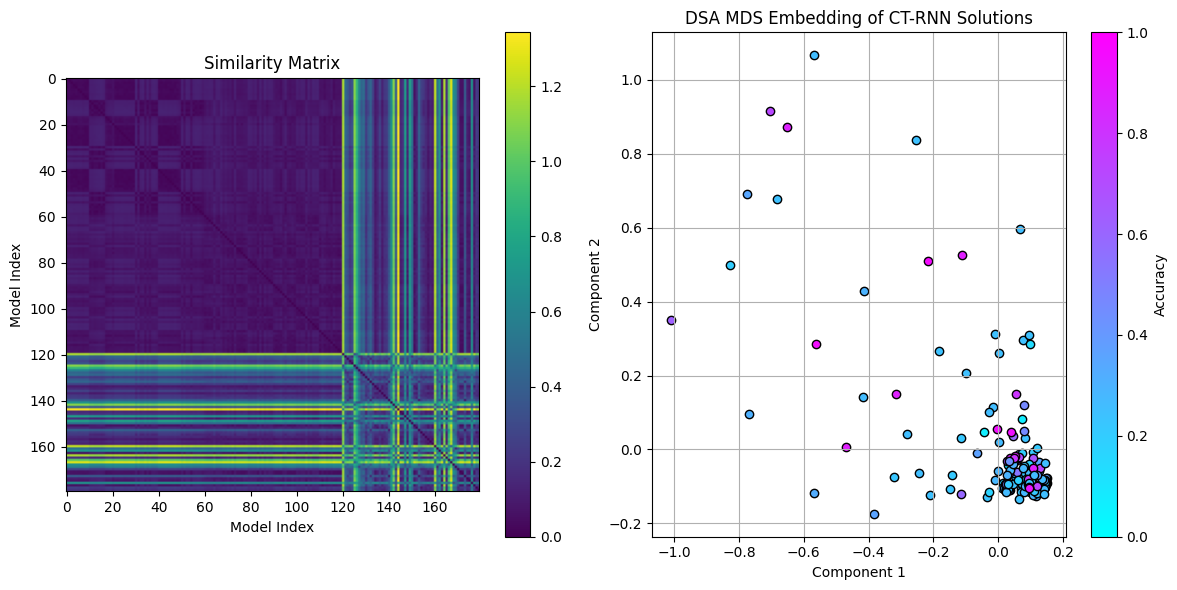

In [12]:
# Setup figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot similarity matrix
im = ax1.imshow(similarity_matrix, cmap="viridis")
ax1.set_title("Similarity Matrix")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("Model Index")
fig.colorbar(im, ax=ax1)

# Plot MDS embedding
cmap = cm.cool
norm = mcolors.Normalize(vmin=0, vmax=1)
for i in range(len(embedding)):
    ax2.scatter(
        embedding[i, 0],
        embedding[i, 1],
        c=[cmap(norm(accuracies[i]))],
        edgecolors="black",
    )

ax2.set_title("DSA MDS Embedding of CT-RNN Solutions")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.grid(True)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label("Accuracy")

plt.tight_layout()
plt.show()